In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise.model_selection import train_test_split
from collections import Counter

### Carregamento dos dados *usando o dataset ml-100k

In [2]:
# Tipos de gêneros (itens)
genre = pd.read_csv('./ml-100k/u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
print("="*60)
print("genre_list:")
print(genre_list)

# Tipos de profissões (usuários)
occupation = pd.read_csv('./ml-100k/u.occupation', sep="|", encoding='latin-1', header=None)
occupation.columns = ['Occupations']
occupation_list = list(occupation['Occupations'])
print("="*60)
print("occupation_list:")
print(occupation_list)

# Carregar os dados das avalições
data = pd.read_csv('./ml-100k/u.data', sep="\t", header=None)
data.columns = ['userId', 'movieId', 'rating', 'timestamp']
print("="*60)
print("data:")
print(data.head())

# Carregar os dados dos filmes
item = pd.read_csv('./ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movieId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item['release'] = pd.to_datetime(item['release'])
item = item[pd.notnull(item['release'])]
item['year'] = item['release'].dt.year.astype(int)
item.drop(columns=['release', 'video release date', 'IMDb URL'], inplace=True)
print("="*60)
print("item:")
print(item.head())

df_meta = item.melt(id_vars=['movieId', 'title'], var_name='genre')
df_meta = df_meta[df_meta.value == 1]
df_meta.drop(columns=['value'], inplace=True)
# df_meta[df_meta['movieId']==1]
print("="*60)
print("meta:")
print(df_meta.head())


# Obter a lista de gêneros de um item
def get_genres(df, movieId):
    if movieId not in df['movieId'].values:
        return []
    return df.loc[(df.movieId==movieId),'genre'].tolist()


def get_counts(recommendations_dict):
    all_items = []
    # Percorre cada usuário e pega a lista de filmes recomendados
    for uid, user_ratings in recommendations_dict.items():
        for (movie_id, rating) in user_ratings:
            all_items.append(movie_id)
    # Retorna um objeto Counter (ex: {filme_A: 50 vezes, filme_B: 2 vezes})
    return Counter(all_items)

# Carregar os dados dos Usuários
user = pd.read_csv('./ml-100k/u.user', sep="|", encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zip code']
print("="*60)
print("user:")
print(user.head())


genre_list:
['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
occupation_list:
['administrator', 'artist', 'doctor', 'educator', 'engineer', 'entertainment', 'executive', 'healthcare', 'homemaker', 'lawyer', 'librarian', 'marketing', 'none', 'other', 'programmer', 'retired', 'salesman', 'scientist', 'student', 'technician', 'writer']
data:
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
item:
   movieId              title  unknown  Action  Adventure  Animation  \
0        1   Toy Story (1995)        0       0          0          1   
1        2   GoldenEye (1995)        0       1          1          0   
2        3  Four Rooms (1995)        0       0

# Implementação de algoritmos de recomendação
## Recomendação dos mais populares (mais avaliados)

Nossa noção de Popularidade para recomendar os itens mais populares é baseada na quantidade de avaliações que tal item possui, não distinguindo as positivas de negativas.
Ele irá recomendar os 10 itens mais populares ainda nçao vistos para cada usuário.
Para esse estudo estamos assumindo que um usuário avalia todos os itens que viu.

In [3]:
# itens a serem reocmendados
N = 10

popularity_counts = data.groupby('movieId').size().reset_index(name='counts')
# Ordenar 
popular_movies_sorted = popularity_counts.sort_values('counts', ascending=False)

# Uso de tuplas para maior performance 
pop_tuples = list(zip(popular_movies_sorted['movieId'], popular_movies_sorted['counts']))

# Determinar que filmes um usuário ja avaliou
user_seen_history = data.groupby('userId')['movieId'].apply(set).to_dict()

def get_popular_unseen_recs(all_user_ids, user_history, n):
    recommendations = {}
    
    for uid in all_user_ids:
        user_recs = []
        seen_movies = user_history.get(uid, set())
        
        # Percorre a lista de populares do topo para baixo
        for movie_id, count in pop_tuples:
            # Só adiciona se o usuário NÃO viu
            if movie_id not in seen_movies:
                user_recs.append((movie_id, count))
            
            # Parar quando encher a lista de 10
            if len(user_recs) == n:
                break
        
        recommendations[uid] = user_recs
        
    return recommendations

all_users = data['userId'].unique()

top_n_popular = get_popular_unseen_recs(all_users, user_seen_history, N)

print("\nExemplo para Usuário 1 (Top 5):")
for mid, count in top_n_popular[1][:5]:
    title = item[item['movieId']==mid]['title'].values[0]
    print(f'{title}')


Exemplo para Usuário 1 (Top 5):
Liar Liar (1997)
English Patient, The (1996)
Scream (1996)
Air Force One (1997)
Titanic (1997)


In [4]:
from collections import defaultdict

# Gera o Top-N recomendações para todos os usuários no conjunto de treino.
def get_top_n_recommendations(algo, trainset, n):
    
    # Criar um Anti-Testset
    # (filmes que o usuário nãoo assistiu)
    testset = trainset.build_anti_testset()
    
    # Prever notas para tudo o que não foi assistido
    predictions = algo.test(testset)
    
    # Mapear previsões para cada usuário
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Ordenar previsões e pegar Top-N
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## SVD++

In [ ]:
from surprise import Dataset, SVDpp, Reader

# Preparação para o SVD
reader = Reader(rating_scale=(1, 5))

# Carregar os dados do Pandas para o Surprise
data_surprise = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

# Construir o conjunto de treino completo
trainset = data_surprise.build_full_trainset()

# Trienar o SVD++
algo_svdpp = SVDpp(random_state=42)
algo_svdpp.fit(trainset)


top_n_svdpp = get_top_n_recommendations(algo_svdpp, trainset, N) # Usando a função antiga

print(f"Recomendações geradas para {len(top_n_svdpp)} usuários.")

In [ ]:
# Ver recomendações do usuário 1
u1_recs = top_n_svdpp[1]
print(f"\nRecomendações para o Usuário 1:")
for movie_id, rating in u1_recs:
    movie_title = item[item['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title} (Nota prevista: {rating:.2f})")


Recomendações para o Usuário 1:
Rear Window (1954) (Nota prevista: 4.95)
Vertigo (1958) (Nota prevista: 4.90)
Some Folks Call It a Sling Blade (1993) (Nota prevista: 4.79)
High Noon (1952) (Nota prevista: 4.76)
Casablanca (1942) (Nota prevista: 4.76)
Ran (1985) (Nota prevista: 4.74)
L.A. Confidential (1997) (Nota prevista: 4.73)
Close Shave, A (1995) (Nota prevista: 4.71)
Harold and Maude (1971) (Nota prevista: 4.69)
Pather Panchali (1955) (Nota prevista: 4.69)


## UserKNN

In [ ]:
from surprise import KNNBasic

algo_knn = KNNBasic(sim_options={'name':'pearson_baseline', 'user_based': True, 'shrinkage': 100}, verbose=False)

algo_knn.fit(trainset)

# Gera 10 recomendações puras do KNN
top_n_knn = get_top_n_recommendations(algo_knn, trainset, N)
total_items = item['movieId'].nunique() 

print(f"Recomendações geradas para {len(top_n_knn)} usuários.")

Recomendações geradas para 943 usuários.


In [ ]:
# Ver recomendações do usuário 1
u1_recs = top_n_knn[1]
print(f"\nRecomendações para o Usuário 1:")
for movie_id, rating in u1_recs:
    movie_title = item[item['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title} (Nota prevista: {rating:.2f})")


Recomendações para o Usuário 1:
So Dear to My Heart (1949) (Nota prevista: 5.00)
Prefontaine (1997) (Nota prevista: 5.00)
Santa with Muscles (1996) (Nota prevista: 5.00)
Great Day in Harlem, A (1994) (Nota prevista: 5.00)
Mina Tannenbaum (1994) (Nota prevista: 5.00)
Anna (1996) (Nota prevista: 5.00)
Story of Xinghua, The (1993) (Nota prevista: 5.00)
Golden Earrings (1947) (Nota prevista: 5.00)
Star Kid (1997) (Nota prevista: 5.00)
Aparajito (1956) (Nota prevista: 5.00)


# Identificação do viés 

## Cobertura de Catálogo (Catalog Coverage)

A Cobertura de Catálogo mede a capacidade do algoritmo de explorar o acervo, ou seja, quantos itens diferentes foram recomendados pelo menos uma vez ao considerar todos os usuários.

Ela é definida matematicamente como:

$$\text{Cobertura} = \left( \frac{\text{Nº de Itens Recomendados (pelo menos 1 vez)}}{\text{Total de Itens no Catálogo}} \right) \times 100$$

Como interpretar os resultados:

**Cobertura Baixa:** Indica forte **Viés de Popularidade**. O modelo criou uma "bolha", recomendando sempre os mesmos itens famosos para todos e ignorando a maior parte do acervo.
**Cobertura Elevada:** Indica que o algoritmo está explorando a **Cauda Longa**. Ele consegue encontrar itens de nicho e entregá-los aos usuários interessados.

Total de Filmes no Catálogo: 1681
Total de Filmes Recomendados (pelo menos 1 vez): 313
Cobertura de Catálogo: 18.62%
Conclusão: O algoritmo ignorou 81.38% dos filmes disponíveis.


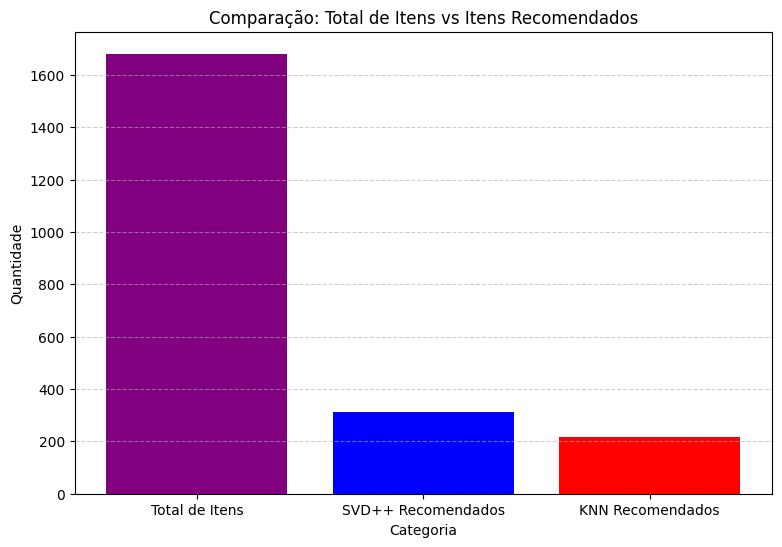

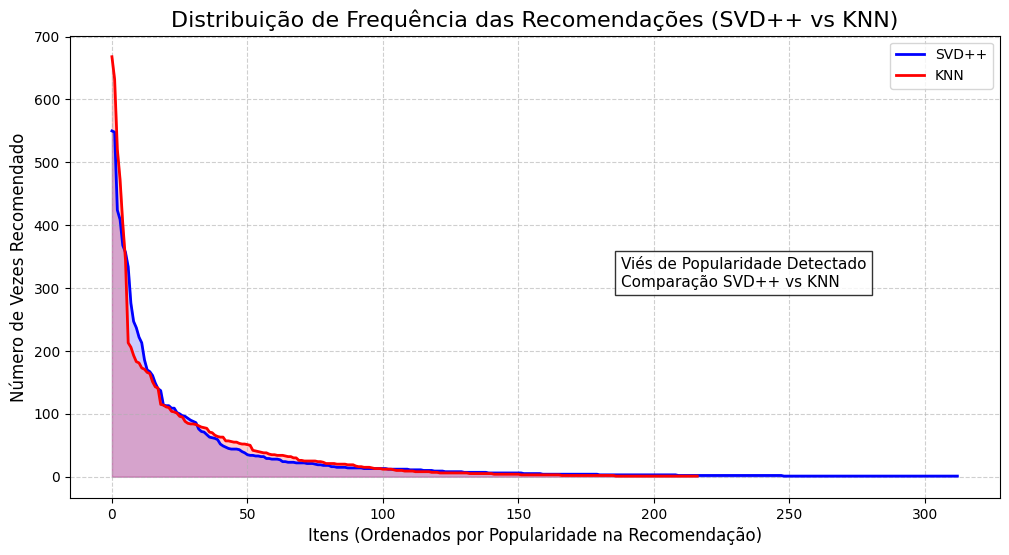

In [ ]:
# Contar quantas vezes cada filme foi recomendado no total 
# Isso é feito para todos os usuários
all_recommended_items = []
for uid, user_ratings in top_n_svdpp.items():
    for (movie_id, rating) in user_ratings:
        all_recommended_items.append(movie_id)

item_counts = Counter(all_recommended_items)

# Preparar dados para o gráfico 
sorted_counts = sorted(item_counts.values(), reverse=True)

# Calcular métricas de identificação
total_items = item['movieId'].nunique()
recommended_unique_items = len(item_counts)
coverage = (recommended_unique_items / total_items) * 100

# Calcular cobertura do KNN
counts_knn = get_counts(top_n_knn)
cov_knn = (len(counts_knn) / total_items) * 100

print(f"Total de Filmes no Catálogo: {total_items}")
print(f"Total de Filmes Recomendados (pelo menos 1 vez): {recommended_unique_items}")
print(f"Cobertura de Catálogo: {coverage:.2f}%")
print(f"Conclusão: O algoritmo ignorou {100 - coverage:.2f}% dos filmes disponíveis.")

# Plotar gráfico de itens totais vs Itens recomendados
labels = ["Total de Itens", "SVD++ Recomendados", "KNN Recomendados"]
values = [total_items, recommended_unique_items, len(counts_knn)]
colors = ["purple", "blue", "red"]

plt.figure(figsize=(9, 6))
plt.bar(labels, values, color=colors)
plt.title("Comparação: Total de Itens vs Itens Recomendados")
plt.ylabel("Quantidade")
plt.xlabel("Categoria")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


# Plotar a Cauda Longa
plt.figure(figsize=(12, 6))

# SVD++ (linha azul)
plt.plot(sorted_counts, color='blue', linewidth=2, label="SVD++")

# KNN (linha vermelha)
sorted_counts_knn = sorted(counts_knn.values(), reverse=True)
plt.plot(sorted_counts_knn, color='red', linewidth=2, label="KNN")

plt.fill_between(range(len(sorted_counts)), sorted_counts, color='blue', alpha=0.2)
plt.fill_between(range(len(sorted_counts_knn)), sorted_counts_knn, color='red', alpha=0.2)

plt.title('Distribuição de Frequência das Recomendações (SVD++ vs KNN)', fontsize=16)
plt.xlabel('Itens (Ordenados por Popularidade na Recomendação)', fontsize=12)
plt.ylabel('Número de Vezes Recomendado', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.text(len(sorted_counts)*0.60, max(sorted_counts)*0.55, 
         f'Viés de Popularidade Detectado\nComparação SVD++ vs KNN', 
         fontsize=11, bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.show()


# Remoção do viés
## 1° Implementação do método de sortear E elementos

o algoritmo escolhera normalmente N-E itens, e explorará outros E, totalizando o top N,
para mudar a variavel E basta alterar no código abaixo

In [ ]:
import random
import numpy as np

# E = itens de exploração
E = 3 

# Consideramos nicho itens com menos de 50 avaliações
popularity_counts = data.groupby('movieId').size().reset_index(name='counts')
niche_df = popularity_counts[popularity_counts['counts'] < 50]
niche_items_list = list(niche_df['movieId'].unique())

def strategy_random_exploration(user_candidates, exploration=3):
    keep_n = 10 - exploration
    top_mainstream = user_candidates[:keep_n] 
    
    # Evitar duplicar
    existing_ids = set([x[0] for x in top_mainstream])
    
    exploration_picks = []
    
    attempts = 0
    # Tentamos sortear até preencher as vagas
    while len(exploration_picks) < exploration and attempts < 100:
        candidate_id = random.choice(niche_items_list)
        
        if candidate_id not in existing_ids:
            existing_ids.add(candidate_id)
        
        attempts += 1
            
    # Combina as duas listas
    return top_mainstream + exploration_picks

# Aplicando no SVD++
print("Aplicando Exploração no SVD++...")
top_10_svdpp_final = {}
for uid, candidates in top_n_svdpp.items():
    top_10_svdpp_final[uid] = strategy_random_exploration(candidates, exploration=E)

# Aplicando no UserKNN 

print("Aplicando Exploração no UserKNN...")
top_10_knn_final = {}
for uid, candidates in top_n_knn.items():
    top_10_knn_final[uid] = strategy_random_exploration(candidates, exploration=E)


Total de Itens na Cauda Longa disponíveis para sorteio: 1079


# Gráfico para comparação entre:
### SVD++ puro
### UserKKN 
### SVD++ com debias
O cob no gráfico é a cobertura de itens que ele abrange em relação ao total

In [ ]:
# Contar SVD Original vs Final Exploration
counts_svdpp = get_counts(top_n_svdpp)
counts_final = get_counts(top_10_svdpp_final)

cov_svd = (len(counts_svdpp) / total_items) * 100
cov_final = (len(counts_final) / total_items) * 100

print(f"Cobertura SVD (Viés): {cov_svd:.2f}%")
print(f"Cobertura Com Exploração: {cov_final:.2f}%")
print(f"Cobertura KNN: {cov_knn:.2f}%")

# Gráfico
plt.figure(figsize=(15, 8))

# Ordenação baseada no SVD (só para ter um eixo X fixo)
all_items_plot = sorted(list(counts_svdpp.keys()), key=lambda x: counts_svdpp[x], reverse=True)

# Preparar dados
y_svd = [counts_svdpp.get(x, 0) for x in all_items_plot]
y_knn = [counts_knn.get(x, 0) for x in all_items_plot]
y_solution = [counts_final.get(x, 0) for x in all_items_plot] 

# Plotar
# Abrangencia do SVD sem o viés# Quantidade de itens únicos recomendados por cada algoritmo
rec_svd = len(counts_svdpp)
rec_final = len(counts_final)
rec_knn = len(counts_knn)

# Labels e valores
labels = ["Total de Itens", "SVD Original", "SVD + Exploração", "KNN"]
values = [total_items, rec_svd, rec_final, rec_knn]
colors = ["purple", "blue", "green", "red"]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=colors)

plt.title("Comparação de Cobertura: SVD vs Exploração vs KNN", fontsize=14)
plt.ylabel("Quantidade de Itens", fontsize=12)
plt.xlabel("Algoritmo", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()



# Comparação dos 3
# SVD azul
plt.fill_between(range(len(all_items_plot)), y_svd, color='blue', alpha=0.2, label=f'SVD Padrão (Cob: {cov_svd:.1f}%)')

# KNN vermelho
plt.plot(y_knn, color='red', linestyle='--', linewidth=1.5, label=f'KNN Item-Based (Cob: {cov_knn:.1f}%)')

# E-Greedy verde 
plt.plot(y_solution, color='green', linewidth=2.5, label=f'SVD + Exploração Aleatória (Cob: {cov_final:.1f}%)')

plt.title('Comparativo de Viés Algorítmico e Estratégia de Mitigação', fontsize=16)
plt.xlabel('Itens do Catálogo (Ordenados por Popularidade)', fontsize=12)
plt.ylabel('Frequência de Recomendação', fontsize=12)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True, alpha=0.3)

plt.show()

## Índice de Gini
Para medir o quão "justo" é o nosso algoritmo, utilizamos conceitos de Economia:

1.  **Curva de Lorenz:** Um gráfico que mostra a distribuição acumulada de recomendações.
    * Se fosse perfeita (Igualdade), seria uma linha reta diagonal.
    * Quanto mais "barriguda" for a curva, maior a desigualdade.
2.  **Índice de Gini:** Um número que resume a curva.
    * 0.0: Igualdade Perfeita (Todos os filmes são recomendados o mesmo tanto).
    * 1.0: Desigualdade Máxima (Um único filme recebe todas as recomendações).

In [ ]:
def plot_comparative_lorenz(models_dict, total_items_count):
    plt.figure(figsize=(10, 10))
    
    # Linha de Igualdade Perfeita
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Igualdade Perfeita (Gini=0.0)')
    
    colors = ['blue', 'red', 'green']
    
    for i, (name, recs) in enumerate(models_dict.items()):
        counts = get_counts(recs)
        
        # Incluir itens com 0 recomendações!
        # Isso é crucial. Se ignorarmos os zeros, o Gini dá errado.
        all_counts = []
        
        # Precisamos iterar sobre TODOS os itens do dataset original (item['movieId'])
        # Supondo que você tem o dataframe 'item' carregado
        all_movie_ids = item['movieId'].unique()
        
        for mid in all_movie_ids:
            all_counts.append(counts.get(mid, 0))
            
        # Ordenar (do menos recomendado para o mais recomendado)
        all_counts.sort()
        
        # Calcular Acumulado (Lorenz)
        # Eixo Y: % Acumulada de Recomendações
        # Eixo X: % Acumulada de Itens
        cum_counts = np.cumsum(all_counts)
        total_recs = cum_counts[-1]
        
        # Evitar divisão por zero
        if total_recs == 0:
            lorenz_curve = np.zeros(len(cum_counts))
        else:
            lorenz_curve = cum_counts / total_recs
            
        # Eixo X normalizado (0 a 1)
        x_axis = np.linspace(0, 1, len(lorenz_curve))
        
        # Calcular Gini (Área A / (A+B))
        # Área sob a curva (trapezoidal)
        area_under_curve = np.trapz(lorenz_curve, x_axis)
        gini = 1 - (2 * area_under_curve)
        
        # Plotar
        color = colors[i % len(colors)]
        plt.plot(x_axis, lorenz_curve, color=color, linewidth=2, 
                 label=f'{name} (Gini: {gini:.3f})')
        
    plt.title('Curva de Lorenz: Comparação de Desigualdade de Exposição', fontsize=16)
    plt.xlabel('% Acumulada de Itens (do menos popular ao mais popular)', fontsize=12)
    plt.ylabel('% Acumulada de Atenção (Recomendações)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Adicionar anotação didática
    plt.text(0.5, 0.2, 'Quanto mais "barriguda"\na curva, maior o Viés ->', 
             fontsize=11, color='gray', ha='center')
    
    plt.show()

# Montar o dicionário com os 3 modelos que já rodamos
modelos_para_comparar = {
    'SVD Padrão (Viés)': top_n_svdpp,
    'KNN (Intermediário)': top_n_knn,
    'Nossa Solução (Exploração)': top_10_svdpp_final
}

plot_comparative_lorenz(modelos_para_comparar, total_items)

In [ ]:
def analyze_rescue(base_recs, solution_recs):
    # Identificar quem o SVD não recomendou
    all_items = set(item['movieId'].unique())
    
    svd_covered = set()
    for uid, recs in base_recs.items():
        for (mid, _) in recs:
            svd_covered.add(mid)
            
    dead_items = all_items - svd_covered
    
    # Ver quantos desses mortos a foram salvos
    solution_covered = set()
    for uid, recs in solution_recs.items():
        for (mid, _) in recs:
            solution_covered.add(mid)
            
    rescued_items = dead_items.intersection(solution_covered)
    
    print(f"Total de Itens ignorados pelo SVD: {len(dead_items)}")
    print(f"Itens salvos pela E-Greedy: {len(rescued_items)}")
    
    success_rate = (len(rescued_items) / len(dead_items)) * 100
    print(f"Taxa de Ressurreição: {success_rate:.1f}% dos filmes esquecidos ganharam vida.")
    
    print("\nExemplos de filmes que ninguém via e agora aparecem:")
    rescued_list = list(rescued_items)[:10] # Pega 10 exemplos
    
    rescued_titles = item[item['movieId'].isin(rescued_list)][['title', 'year']]
    try:
        display(rescued_titles)
    except:
        print(rescued_titles)

# Executar
analyze_rescue(top_n_svdpp, top_10_svdpp_final)

In [ ]:
# Mede o quão "batidos" (populares) são os filmes recomendados.
# Quanto MENOR o número, MAIS NOVIDADE você está trazendo (Isso é bom!)

def calculate_novelty(recommendations_dict):
    total_popularity = []
    
    # Criar dicionário rápido de popularidade se não tiver
    # popularity_counts já foi criado lá no começo (passo 1)
    pop_map = dict(zip(popularity_counts['movieId'], popularity_counts['counts']))
    
    for uid, user_recs in recommendations_dict.items():
        user_pop = []
        for (mid, rating) in user_recs:
            # Pegar quantos votos o filme tem no total (popularidade)
            pop = pop_map.get(mid, 0)
            user_pop.append(pop)
        
        # Média de popularidade da lista desse usuário
        if user_pop:
            total_popularity.append(sum(user_pop) / len(user_pop))
    
    # Média global de todos os usuários
    return sum(total_popularity) / len(total_popularity)

# Calcular
nov_svd = calculate_novelty(top_n_svdpp)
nov_final = calculate_novelty(top_10_svdpp_final)

print(f"Popularidade Média dos itens SVD: {nov_svd:.0f} avaliações por filme")
print(f"Popularidade Média dos itens E=Greedy: {nov_final:.0f} avaliações por filme")

# Interpretação Automática
drop = ((nov_svd - nov_final) / nov_svd) * 100
print(f"\nRecomenda itens {drop:.1f}% menos óbvios que o SVD.")

# Gráfico
plt.figure(figsize=(12, 8))
bars = plt.bar(['SVD (Mainstream)', 'E-Greedy deterministico'], [nov_svd, nov_final], color=['gray', 'purple'])
plt.ylabel('Média de Popularidad')
plt.title('Nível de Obviedade das Recomendações')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=12)

plt.show()

### A Bolha de Filtro é Programável e Evitável

Este experimento demonstrou que as **Bolhas de Filtro** não são acidentes, mas consequências matemáticas diretas de como desenhamos nossos algoritmos.

**O que os dados provaram:**
* **A Bolha é Real:** O algoritmo padrão (SVD) focou excessivamente na popularidade, escondendo **mais de 80%** do catálogo cultural disponível. Isso cria uma experiência de usuário repetitiva e excludente.
* **A Bolha é Rompível:** Com uma simples intervenção de código (**Exploração Aleatória**), conseguimos quadruplicar a cobertura do catálogo (para **72%**) e "ressuscitar" centenas de filmes de alta qualidade que estavam invisíveis.